In [2]:
import pandas as pd
import numpy as np
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io
# to read multiple images
import glob

In [3]:
def img2layered(image):
    
    import pandas as pd
    import numpy as np
    import cv2
    import numpy as np
    from matplotlib import pyplot as plt
    from scipy import ndimage
    from skimage import measure, color, io
    # to read multiple images
    import glob
    
    #img = cv2.imread(image)

    #Extract only blue channel as DAPI / nuclear (blue) staining is the best
    #channel to perform cell count.
    cells=img[:,:,0]  #Blue channel. Image equivalent to grey image.

    pixels_to_um = 0.454 # 1 pixel = 454 nm (got this from the metadata of original image)

    #Threshold image to binary using OTSU. ALl thresholded pixels will be set to 255
    ret1, thresh = cv2.threshold(cells, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


    # Morphological operations to remove small noise - opening
    #To remove holes we can use closing
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

    from skimage.segmentation import clear_border
    opening = clear_border(opening) #Remove edge touching grains
    #Check the total regions found before and after applying this. 

    #Now we know that the regions at the center of cells is for sure cells
    #The region far away is background.
    #We need to extract sure regions. For that we can use erode. 
    #But we have cells touching, so erode alone will not work. 
    #To separate touching objects, the best approach would be distance transform and then thresholding.

    # let us start by identifying sure background area
    # dilating pixes a few times increases cell boundary to background. 
    # This way whatever is remaining for sure will be background. 
    #The area in between sure background and foreground is our ambiguous area. 
    #Watershed should find this area for us. 
    sure_bg = cv2.dilate(opening,kernel,iterations=5)

    #cv2.imshow('Sure Background', sure_bg)
    #cv2.waitKey(0)

    # Finding sure foreground area using distance transform and thresholding
    #intensities of the points inside the foreground regions are changed to 
    #distance their respective distances from the closest 0 value (boundary).
    #https://www.tutorialspoint.com/opencv/opencv_distance_transformation.htm
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)


    #Let us threshold the dist transform by starting at 1/2 its max value.
    #print(dist_transform.max()) gives about 21.9
    ret2, sure_fg = cv2.threshold(dist_transform,0.25*dist_transform.max(),255,0)

    #Later you realize that 0.25* max value will not separate the cells well.
    #High value like 0.7 will not recognize some cells. 0.5 seems to be a good compromize

    # Unknown ambiguous region is nothing but bkground - foreground
    sure_fg = np.uint8(sure_fg)
    #cv2.imshow('Sure fg', sure_fg)
    #cv2.waitKey(0)
    unknown = cv2.subtract(sure_bg,sure_fg)

    #Now we create a marker and label the regions inside. 
    # For sure regions, both foreground and background will be labeled with positive numbers.
    # Unknown regions will be labeled 0. 
    #For markers let us use ConnectedComponents. 
    ret3, markers = cv2.connectedComponents(sure_fg)

    #One problem rightnow is that the entire background pixels is given value 0.
    #This means watershed considers this region as unknown.
    #So let us add 10 to all labels so that sure background is not 0, but 10
    markers = markers+10

    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    #plt.imshow(markers, cmap='jet')   #Look at the 3 distinct regions.

    #Now we are ready for watershed filling. 
    markers = cv2.watershed(img,markers)
    #The boundary region will be marked -1
    #https://docs.opencv.org/3.3.1/d7/d1b/group__imgproc__misc.html#ga3267243e4d3f95165d55a618c65ac6e1

    #Let us color boundaries. 
    img[markers == -1] = [0,255,255]  
       
    return img

['C:\\Users\\sotka\\Desktop\\exam_projects\\Data_Engineer-candidate_assessment_CellVoyant\\Test\\E11_11-1.ome_8bit.tif', 'C:\\Users\\sotka\\Desktop\\exam_projects\\Data_Engineer-candidate_assessment_CellVoyant\\Test\\E11_11-10.ome_8bit.tif', 'C:\\Users\\sotka\\Desktop\\exam_projects\\Data_Engineer-candidate_assessment_CellVoyant\\Test\\E11_11-11.ome_8bit.tif', 'C:\\Users\\sotka\\Desktop\\exam_projects\\Data_Engineer-candidate_assessment_CellVoyant\\Test\\E11_11-12.ome_8bit.tif', 'C:\\Users\\sotka\\Desktop\\exam_projects\\Data_Engineer-candidate_assessment_CellVoyant\\Test\\E11_11-13.ome_8bit.tif', 'C:\\Users\\sotka\\Desktop\\exam_projects\\Data_Engineer-candidate_assessment_CellVoyant\\Test\\E11_11-14.ome_8bit.tif', 'C:\\Users\\sotka\\Desktop\\exam_projects\\Data_Engineer-candidate_assessment_CellVoyant\\Test\\E11_11-15.ome_8bit.tif', 'C:\\Users\\sotka\\Desktop\\exam_projects\\Data_Engineer-candidate_assessment_CellVoyant\\Test\\E11_11-16.ome_8bit.tif', 'C:\\Users\\sotka\\Desktop\\exam

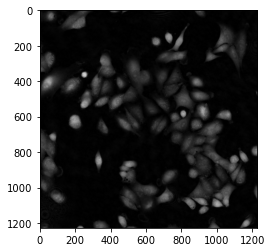

In [4]:
path = r"C:\Users\sotka\Desktop\exam_projects\Data_Engineer-candidate_assessment_CellVoyant\Test\*.*"
file_list = glob.glob(path) #Rerurns a list of file names
print(file_list)  #Prints the list containing file names

#Now let us load each file at a time...
my_list=[]  #Empty list to store images from the folder.
for file in glob.glob(path):   #Iterate through each file in the list using for
    #print(file)     #just stop here to see all file names printed
    a= cv2.imread(file)  #now, we can read each file since we have the full path
    my_list.append(a)  #Create a list of images (not just file names but full images)
    
#View images from the stored list
from matplotlib import pyplot as plt
print(type(my_list[2]))
plt.imshow(my_list[2])  #View the 3rd image in the list.

20
<class 'numpy.ndarray'>


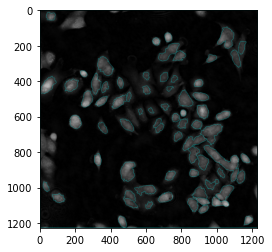

In [18]:
# converting images to layered via a custom function
layered = []
for img in file_list:
    img = cv2.imread(img)
    img = img2layered(img)
    layered.append(img)
    
print(type(layered[0]))
plt.imshow(layered[0])  

In [14]:
# short version of the image names
short_names = [name.split('\\')[-1] for name in file_list]
short_names = [name.split('.')[0] for name in short_names]
print(short_names)

['E11_11-1', 'E11_11-10', 'E11_11-11', 'E11_11-12', 'E11_11-13', 'E11_11-14', 'E11_11-15', 'E11_11-16', 'E11_11-17', 'E11_11-18', 'E11_11-19', 'E11_11-2', 'E11_11-20', 'E11_11-3', 'E11_11-4', 'E11_11-5', 'E11_11-6', 'E11_11-7', 'E11_11-8', 'E11_11-9']


In [20]:
# save to file
import os.path

output_path = r'C:\Users\sotka\Desktop\exam_projects\Data_Engineer-candidate_assessment_CellVoyant\Test_Layered'

i = 0
for layer in layered:
    cv2.imwrite(os.path.join(output_path, short_names[i]+'_layered.tif'), layer)
    i += 1